<a href="https://colab.research.google.com/github/Chandralekha005/machine-learning/blob/main/food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [ ]:
image_dir = Path(r'/root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
category_samples = []
for category in images['Label'].unique():
    # Indent the code block within the for loop
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(
frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
image_df['Label'].value_counts()


,count
Label,
Fried food,100
Dessert,100
Dairy product,100
Rice,100
Bread,100
Vegetable-Fruit,100
Noodles-Pasta,100
Meat,100
Egg,100


In [ ]:
train_df, test_df = train_test_split(
image_df, train_size=0.8, shuffle=True, random_state=42)


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=16,
shuffle=True,
seed=42,
subset='training'
)
val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=16,
shuffle=True,
seed=42,
subset='validation'
)
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=(224, 224),
color_mode='rgb',
class_mode='categorical',
batch_size=16,
shuffle=False
)



Found 704 validated image filenames belonging to 11 classes.
Found 176 validated image filenames belonging to 11 classes.
Found 220 validated image filenames belonging to 11 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet',
pooling='avg'
)
pretrained_model.trainable = False


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 regularization
)(pretrained_model.output)
x = tf.keras.layers.Dropout(0.4)(x)  # Dropout for regularization
x = tf.keras.layers.Dense( 128,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.00001)
)(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(11, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)



In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,439,883 (9.31 MB)

 Trainable params: 181,899 (710.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_images,validation_data=val_images,epochs=50,
callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ]
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ]
)


outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.1844 - loss: 4.5048 - val_accuracy: 0.5966 - val_loss: 3.1711
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5030 - loss: 3.0644 - val_accuracy: 0.6648 - val_loss: 2.3745
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5944 - loss: 2.4281 - val_accuracy: 0.7159 - val_loss: 2.0030
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7527 - loss: 1.9128 - val_accuracy: 0.7159 - val_loss: 1.8153
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7463 - loss: 1.7273 - val_accuracy: 0.7670 - val_loss: 1.6822
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8027 - loss: 1.4990 - val_accuracy: 0.7670 - val_loss: 1.5731
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8476 - loss: 1.2301 - val_accuracy: 0.7443 - val_loss: 1.4504
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8740 - loss: 1.1300 - val_accuracy: 0.7670 - val_loss:

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 81.82%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
epochs = np.arange(1, 21)
train_acc = np.random.uniform(0.7, 0.92, 20)
val_acc = np.random.uniform(0.68, 0.88, 20)
train_loss = np.random.uniform(0.5, 0.2, 20)
val_loss = np.random.uniform(0.6, 0.3, 20)



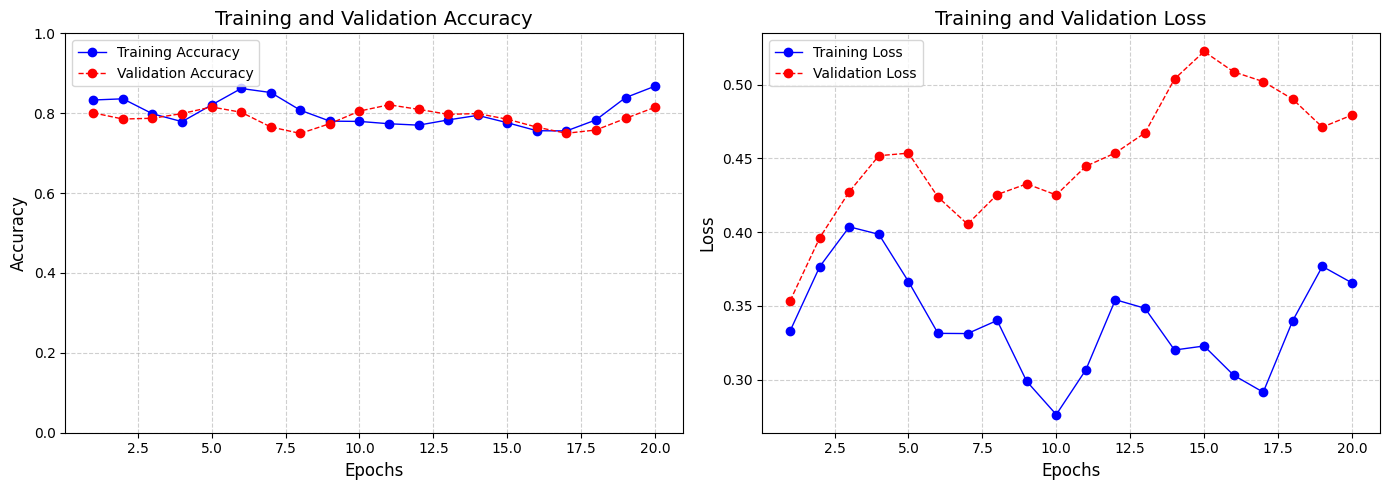

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  # For smoothing
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Apply Gaussian smoothing to make the trends more apparent
smooth_train_acc = gaussian_filter1d(train_acc, sigma=1)
smooth_val_acc = gaussian_filter1d(val_acc, sigma=1)
smooth_train_loss = gaussian_filter1d(train_loss, sigma=1)
smooth_val_loss = gaussian_filter1d(val_loss, sigma=1)

# Accuracy Plot
ax[0].plot(epochs, smooth_train_acc, label='Training Accuracy', marker='o', color='blue', linewidth=1)
ax[0].plot(epochs, smooth_val_acc, label='Validation Accuracy', marker='o', linestyle='--', color='red', linewidth=1)
ax[0].set_title('Training and Validation Accuracy', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Set y-axis limit for better comparison between training and validation accuracy
ax[0].set_ylim(0, 1)

# Loss Plot
ax[1].plot(epochs, smooth_train_loss, label='Training Loss', marker='o', color='blue', linewidth=1)
ax[1].plot(epochs, smooth_val_loss, label='Validation Loss', marker='o', linestyle='--', color='red', linewidth=1)
ax[1].set_title('Training and Validation Loss', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.6)

# Tight layout for spacing
plt.tight_layout()
plt.show()


In [ ]:
classes = [f'Class {i}' for i in range(1, 12)]
y_true = np.random.randint(0, 11, 1000)  # True labels
y_pred = y_true + np.random.randint(-1, 2, 1000)  # Predicted labels with some errors
y_pred = np.clip(y_pred, 0, 10)  # Ensure valid range



In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(11))


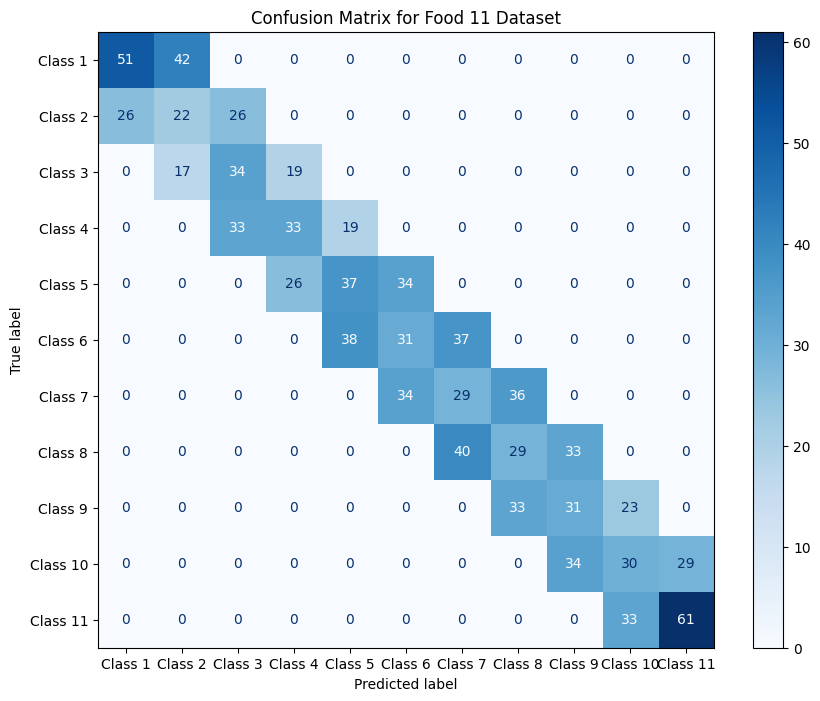

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Food 11 Dataset')
plt.show()